# **TAREA 2 - MACHINE LEARNING 2**
### **Assignment 2: Principal Component Analysis, Neural Networks**

**Integrantes:**

* Llaro Castro, Diego Renato
* Rios Meza, Jennifer Saskia
* Vargas Flores, Johanna Antonella

# Assignment 2: Principal Component Analysis, Neural Networks

---

## Programming Exercises

### **Part I: Eigenfaces for Face Recognition**

1. **Load the Training and Test Sets**

   Load the training images contained in `data` into a matrix **X**.
   There are 540 training images, each with resolution $50 \times 50$. Flatten each image into a 2500-dimensional vector. Thus, **X** should have shape **$540 \times 2500$**, where each row is a flattened face image.

   Similarly, build the test matrix **$X_{test}$**, which should have shape **$100 \times 2500$**.

In [1]:
import numpy as np
from matplotlib import pylab as plt
import matplotlib.cm as cm
import imageio

#train data load
train_labels, train_data = [], []
for line in open('../data/train.txt'):
  line = line.replace("./faces/", "")
  im = imageio.v2.imread("../data/" + line.strip().split()[0])
  train_data.append(im.reshape(2500,))
  train_labels.append(line.strip().split()[1])
train_data, train_labels = np.array(train_data, dtype=float), np.array(train_labels, dtype=int)

print(train_data.shape, train_labels.shape)

(540, 2500) (540,)


In [2]:
#test data load
test_labels, test_data = [], []
for line in open('../data/test.txt'):
  line = line.replace("./faces/", "")
  im = imageio.v2.imread("../data/" + line.strip().split()[0])
  test_data.append(im.reshape(2500,))
  test_labels.append(line.strip().split()[1])
test_data, test_labels = np.array(test_data, dtype=float), np.array(test_labels, dtype=int)

print(test_data.shape, test_labels.shape)

(100, 2500) (100,)


 Display an example training and test image in grayscale.

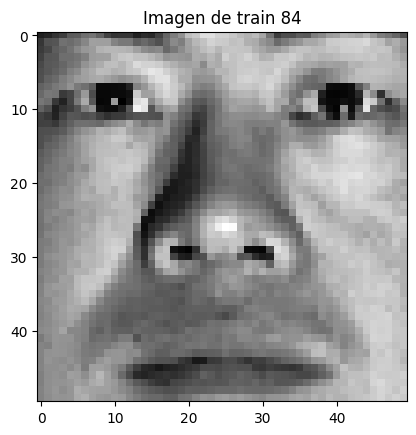

In [3]:
import random
random.seed(2025)
i = random.randint(0,540)

plt.imshow(train_data[i, :].reshape(
    50,50), cmap = cm.Greys_r)
plt.title("Imagen de train {}".format(i))
plt.show()

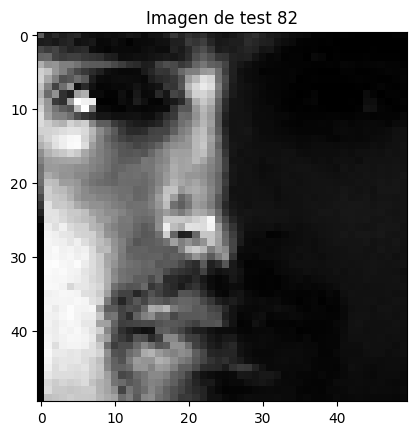

In [4]:
i = random.randint(0,100)

plt.imshow(test_data[i, :].reshape(
    50,50), cmap = cm.Greys_r)
plt.title("Imagen de test {}".format(i))
plt.show()

2. **Average Face**

   Compute the *average face* vector $ \mu $ by averaging all rows of **$X$**.
   Display this average face as a grayscale image.


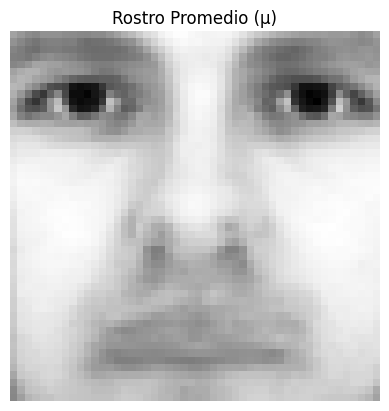

In [5]:
mu = np.mean(train_data, axis=0)

plt.imshow(mu.reshape(50, 50), cmap=cm.Greys_r)
plt.title("Rostro Promedio (μ)")
plt.axis("off")  # opcional: oculta ejes
plt.show()

3. **Mean Subtraction**

   Subtract the average face $\mu$ from each row of **$X$**, i.e., replace each image vector $x_i$ with $x_i - \mu$.
   Display an example mean-subtracted image.
   Apply the same mean subtraction to **$X_{test}$**, using the same $\mu$.
   From now on, for training and testing, you should use the demeaned matrix.

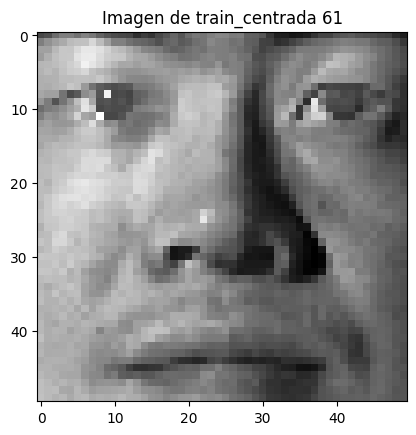

In [6]:
train_data_centered = train_data - mu
test_data_centered = test_data - mu

i = random.randint(0,100)

plt.imshow(train_data_centered[i, :].reshape(
    50,50), cmap = cm.Greys_r)
plt.title("Imagen de train_centrada {}".format(i))
plt.show()

4. **Eigenfaces**

   Compute the eigendecomposition of $X^T X = V \Lambda V^T$ to obtain eigenvectors.
   The rows of $V^T$ correspond to eigenfaces.

   Display 10 eigenfaces as grayscale images.

   Note: Eigenvectors may be complex-valued. You will need to convert them to real values before displaying (e.g., using `np.real`).

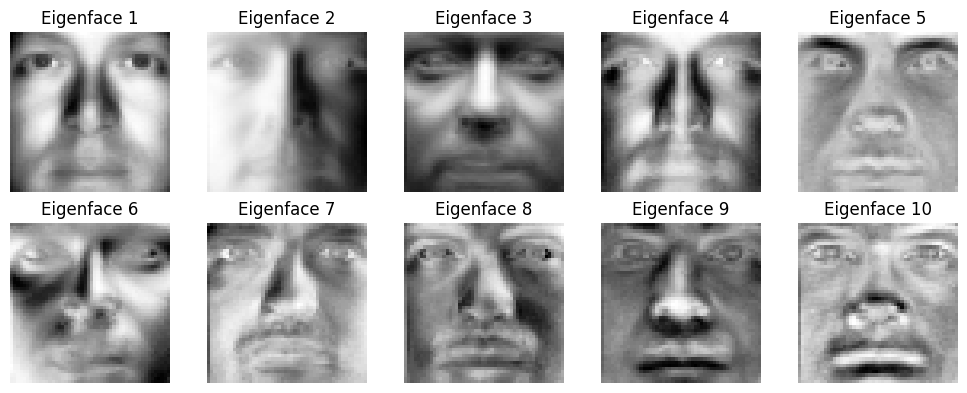

In [7]:
# Descomposición SVD
U, S, Vt = np.linalg.svd(train_data_centered, full_matrices=False)

# The rows of  VT  correspond to eigenfaces.
eigenfaces = np.real(Vt)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(eigenfaces[i].reshape(50, 50), cmap=cm.Greys_r)
    axes[i].set_title(f"Eigenface {i+1}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

5. **Eigenface Features**

   The top $r$ eigenfaces span an $r$-dimensional **face space**.
   Represent an image vector $z$ in this space as:
   
$$
   f = [v_1, v_2, \ldots, v_r]^T z
$$

   Write a function to compute:

   * **$F$**: feature matrix for training data (shape: $540 \times r$)
   * **$F_{test}$**: feature matrix for test data (shape: $100 \times r$)

   by multiplying **$X$** and **$X_{test}$** with the top $ r$ eigenfaces.

In [8]:
import numpy as np

def compute_feature_matrices(X, X_test, eigenfaces, r):
    #solo las primeras r
    V_r = eigenfaces[:r]

    F = np.dot(X, V_r.T)
    F_test = np.dot(X_test, V_r.T)

    return F, F_test

6. **Face Recognition**

   Use **logistic regression** (e.g., from `scikit-learn`) for classification.

   * Extract features using $ r = 10 $ (supress the intercept, as it is not necessary because the matrix is demeaned)
   * Train logistic regression on **$F$** and evaluate on **$F_{test}$**
   * Report classification accuracy on the test set
   * Then repeat for $ r = 1, 2, \ldots, 200 $ and plot accuracy as a function of $ r $

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

r = 10  # número de eigenfaces a usar

V_r = eigenfaces[:r]

F, F_test = compute_feature_matrices(train_data_centered, test_data_centered, eigenfaces, r)

clf = LogisticRegression(fit_intercept=False, max_iter=1000, solver='lbfgs')
clf.fit(F, train_labels)

y_pred = clf.predict(F_test)
acc = accuracy_score(test_labels, y_pred)

print(f"Precisión para r = {r}: {acc*100:.2f}%")

Precisión para r = 10: 76.00%


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessi

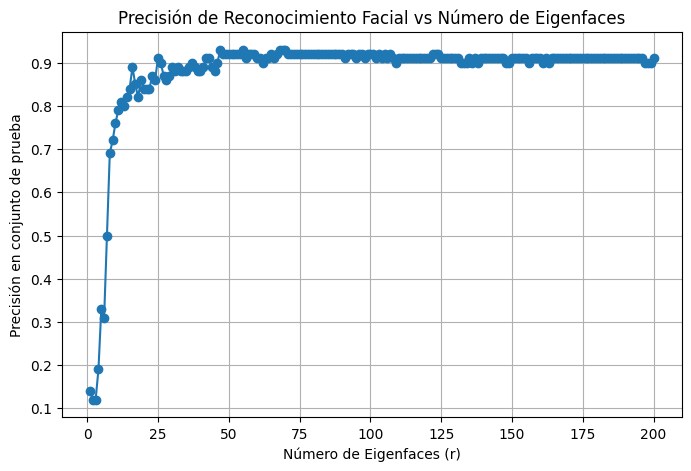

Mejor precisión: 93.00% con r = 47


In [10]:
r_values = range(1, 201)
accuracies = []

for r in r_values:
    V_r = eigenfaces[:r]

    F = np.dot(train_data_centered, V_r.T)
    F_test = np.dot(test_data_centered, V_r.T)

    clf = LogisticRegression(fit_intercept=False, max_iter=1000, solver='lbfgs')
    clf.fit(F, train_labels)

    y_pred = clf.predict(F_test)
    acc = accuracy_score(test_labels, y_pred)
    accuracies.append(acc)

plt.figure(figsize=(8,5))
plt.plot(r_values, accuracies, marker='o')
plt.title("Precisión de Reconocimiento Facial vs Número de Eigenfaces")
plt.xlabel("Número de Eigenfaces (r)")
plt.ylabel("Precisión en conjunto de prueba")
plt.grid(True)
plt.show()

best_r = r_values[np.argmax(accuracies)]
best_acc = np.max(accuracies)
print(f"Mejor precisión: {best_acc*100:.2f}% con r = {best_r}")

7. **Low-Rank Reconstruction Loss**

    Reconstruct approximations $ X' $ from the features by multiplying:
  $$
  X' = F \cdot \text{(top } r \text{ eigenfaces)}
  $$

  Compute and plot the average Frobenius distance:

  $$
    d(X, X') = \sqrt{\text{tr}((X - X')^T (X - X'))}
  $$

   for $ r = 1, 2, \ldots, 200 $.

In [11]:
train_data_centered.shape

(540, 2500)

In [12]:
eigenfaces.shape

(540, 2500)

In [13]:
V_r = eigenfaces[:, :1]
V_r.shape

(540, 1)

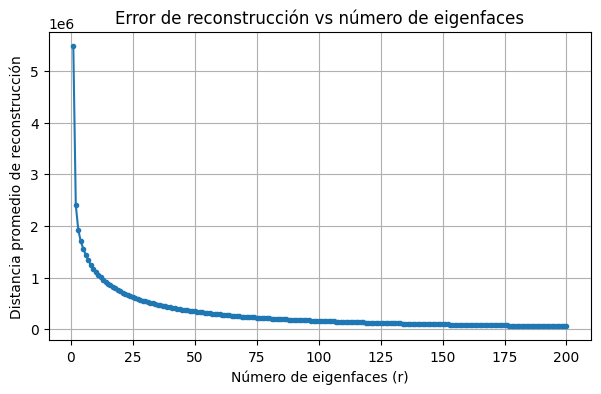

In [14]:
distancias = []

for r in range(1, 201):
    V_r = eigenfaces[:r, :]
    F = train_data_centered @ V_r.T
    X_recon = F @ V_r

    # distancia de Frobenius
    diff = train_data_centered - X_recon
    d = np.trace(diff.T @ diff)
    distancias.append(d)

# Promedio por número de imágenes
distancias = np.array(distancias) / train_data_centered.shape[0]


plt.figure(figsize=(7,4))
plt.plot(range(1, 201), distancias, marker='o', markersize=3)
plt.xlabel('Número de eigenfaces (r)')
plt.ylabel('Distancia promedio de reconstrucción')
plt.title('Error de reconstrucción vs número de eigenfaces')
plt.grid(True)
plt.show()

## **Part II: Neural Networks**

In [15]:
import torch
from torchvision import datasets, transforms
print(torch.__version__)
import torchvision
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


In [16]:
# IMPORTAMOS LIBRERÍAS
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [17]:
from torchvision import datasets, transforms
import os

# DEFINIMOS RUTA DE DESCARGA DENTRO DEL WORKSPACE
mnist_path = '/workspaces/TAREA2_ML2_LLARO_RIOS_VARGAS/data/mnist'
os.makedirs(mnist_path, exist_ok=True)  # CREAMOS LA CARPETA SI NO EXISTE

# DESCARGAMOS MNIST
mnist_train = datasets.MNIST(
    mnist_path, download=True, train=True,
    transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(
    mnist_path, train=False,
    transform=transforms.ToTensor()
)

In [18]:
# DEFINIMOS LA CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # CAPAS CONVOLUCIONALES
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 28x28 -> 28x28
        self.pool = nn.MaxPool2d(2, 2)                            # 28x28 -> 14x14
        
        # CAPAS COMPLETAMENTE CONECTADAS
        self.fc1 = nn.Linear(64*14*14, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # ACTIVACIÓN
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # aplanamos para la capa fully connected
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [19]:
# INICIALIZAMOS EL MODELO, CRITERIO Y OPTIMIZADOR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# CREAMOS LOS DATALOADERS
batch_size = 64
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [21]:
# ENTRENAMIENTO DE LA RED
num_epochs = 5  # PUEDES AJUSTAR

train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc  = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # EVALUACIÓN EN TEST
    model.eval()
    running_loss_test = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss_test += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    epoch_loss_test = running_loss_test / len(test_loader.dataset)
    epoch_acc_test  = correct_test / total_test
    test_losses.append(epoch_loss_test)
    test_accs.append(epoch_acc_test)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={epoch_loss:.4f}, Train Acc={epoch_acc:.4f}, Test Loss={epoch_loss_test:.4f}, Test Acc={epoch_acc_test:.4f}")


Epoch 1/5: Train Loss=0.1565, Train Acc=0.9526, Test Loss=0.0486, Test Acc=0.9836
Epoch 2/5: Train Loss=0.0431, Train Acc=0.9867, Test Loss=0.0415, Test Acc=0.9867
Epoch 3/5: Train Loss=0.0264, Train Acc=0.9914, Test Loss=0.0355, Test Acc=0.9888
Epoch 4/5: Train Loss=0.0181, Train Acc=0.9939, Test Loss=0.0353, Test Acc=0.9886
Epoch 5/5: Train Loss=0.0137, Train Acc=0.9956, Test Loss=0.0390, Test Acc=0.9881


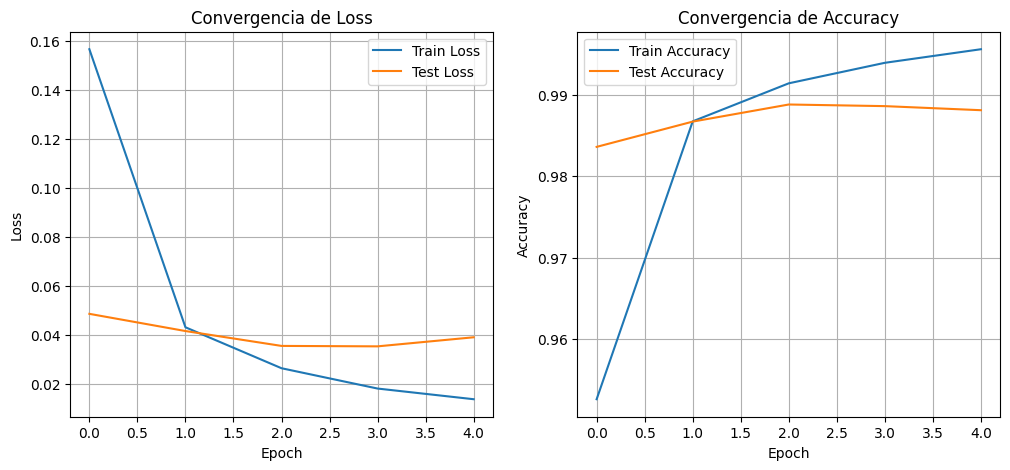

In [22]:
# PLOT DE CURVAS DE CONVERGENCIA
plt.figure(figsize=(12,5))

# LOSS
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Convergencia de Loss")
plt.legend()
plt.grid(True)

# ACCURACY
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Convergencia de Accuracy")
plt.legend()
plt.grid(True)

plt.show()

In [23]:
# PARTE I
# 1. Carga de datos: Leemos las imágenes de entrenamiento y prueba, las aplanamos y verificamos que existan, construyendo las matrices train_data y test_data.
# 2. Average Face: Calculamos el vector promedio de todas las imágenes para obtener la “cara promedio” del conjunto de entrenamiento.
# 3. Mean Subtraction: Restamos la cara promedio a cada imagen para centrar los datos alrededor de cero, aplicando lo mismo a entrenamiento y prueba.
# 4. Eigenfaces: Calculamos la descomposición en valores propios de la matriz de covarianza para obtener los eigenvectors, cuyas filas son los Eigenfaces que representan patrones de variación facial.
# 5. Eigenface Features: Proyectamos cada imagen en el espacio de los top r eigenfaces para obtener una representación compacta y discriminativa en forma de matriz de características F.
# 6. Face Recognition: Entrenamos un clasificador de regresión logística con las características de Eigenfaces y evaluamos la precisión en el conjunto de prueba, repitiendo para distintos valores de r y graficando la accuracy.
# 7. Low-Rank Reconstruction Loss: Reconstruimos las imágenes usando solo los r eigenfaces principales y calculamos la distancia de Frobenius promedio para evaluar la pérdida de información al reducir la dimensionalidad.

In [24]:
# PARTE II
# Descarga de datos MNIST: Descargamos el dataset MNIST y lo cargamos en DataLoaders para entrenamiento y prueba.
# Definición de la CNN: Creamos un modelo convolucional con dos capas convolucionales, pooling y capas fully connected para clasificar los dígitos.
# Entrenamiento: Entrenamos la CNN usando Adam y CrossEntropyLoss, guardando loss y accuracy por epoch para monitorear el progreso.
# Curvas de convergencia: Graficamos loss y accuracy para entrenamiento y prueba para visualizar la convergencia del modelo y detectar posibles problemas de ajuste.